<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

Using meta_analysis data with bigger taining data.

Using 3000 highly variable genes without gene_missing features.

1. Batch data.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. Modified R2 score
5. Gene normalization

TODO:
  - Normalize all the data in the same way.
  - Before normalizign the more_data, take care of data with only zeros for the gene expression.

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/'Colab Notebooks'
# !pip -q install torcheval
# !pip -q install datasets
# path = Path('data/circadian')
path = Path('data')
bulk_path = Path.home()/'Downloads/data'

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
loss_func = F.mse_loss

In [5]:
class TimeLayer(nn.Module):
    def __init__(self, range = 24):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

In [6]:
from torcheval.metrics import R2Score
# metric = MetricsCB(R2Score=R2Score())
# metric = R2Score()

In [7]:
class TimeR2Score(R2Score):
    def update(self, input, target):
        inp = input.clone()
        for i, (x, y) in enumerate(zip(input, target)):
            min_x = x
            min_diff = torch.inf
            for z in [x-24, x, x+24]:
                if abs(z-y) < min_diff:
                    min_diff = abs(z-y)
                    min_x = z
            inp[i] = min_x
        super().update(inp, target)

In [8]:
metric = MetricsCB(R2Score=TimeR2Score())

## Data

<img src="cell_nrm.jpg" alt="Cell normalization" width="400">

In [9]:
def nrm_genes(df):
    """Assuming genes on cols cells on rows."""
    cell_divided = df.div(df.sum(axis=1), axis=0)
    return (cell_divided - cell_divided.mean(axis=0)) / cell_divided.std(axis=0)

In [10]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False, index_col='cell_name')
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [11]:
data = nrm_genes(raw_data.set_index('gene').T)
data

gene,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Fam228a,Tmtc4,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora
AAACAGCCAACCCTAA-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,0.973655,1.596216,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
AAACCAACAGTAAAGC-6,-0.084609,0.102471,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,-0.360944,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,3.229633
AAACCGAAGGTCCTAG-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,1.321811,-0.412951,0.037968,-0.009154,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
AAAGCACCATTGTCCT-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,0.272407,0.120047,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
AAAGGACGTGAGGTGA-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,-1.003653,3.640279,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCCGTCGCACAAT-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,1.314387,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
TTGCGTCTCTTAGTCT-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,-0.327298,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
TTGGGTTAGCCACAAT-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,0.976245,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717
TTTAGCTTCAGGAAGC-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.252843,-0.412951,-1.003653,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717


In [12]:
data['code'] = meta_data.loc[:,'ZT'].str[-2:].map(float)
df = data
df

gene,Meg3,Slc1a2,Rian,Cyp2c40,Cyp2c69,Sgcz,Glul,Ugt2b37,Tmeff2,B830012L14Rik,...,Tmtc4,Mpp6,Ralgps1,Zfp580,Sept8,Cfap52,Arhgap27,F730043M19Rik,Bora,code
AAACAGCCAACCCTAA-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,0.973655,1.596216,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,18.0
AAACCAACAGTAAAGC-6,-0.084609,0.102471,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,-0.360944,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,3.229633,18.0
AAACCGAAGGTCCTAG-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,0.037968,-0.009154,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,18.0
AAAGCACCATTGTCCT-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,0.272407,0.120047,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,18.0
AAAGGACGTGAGGTGA-6,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,-1.003653,3.640279,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCCGTCGCACAAT-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,1.314387,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,6.0
TTGCGTCTCTTAGTCT-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,-0.327298,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,6.0
TTGGGTTAGCCACAAT-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,0.976245,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,6.0
TTTAGCTTCAGGAAGC-7,-0.084609,-0.290236,-0.078337,-0.127326,-0.089019,-0.188819,-0.260546,-0.048848,-0.090508,-0.065885,...,-0.412951,-1.003653,-0.583197,-0.033528,-0.031006,-0.025706,-0.03159,-0.032271,-0.273717,6.0


### Bulk + scRNA-seq

In [13]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [14]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [16]:
bulk_data = nrm_genes(raw_bulk_data.set_index('ID').T)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [17]:
gro = nrm_genes(raw_gro.set_index('ID').T)
nascent = nrm_genes(raw_nascent.set_index('ID').T)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [18]:
bulk_data

ID,2810459M11Rik,Abcb11,Acot7,Ahctf1,Ap2a2,Asb13,Asl,Chka,Clic3,Clpx,...,Ap1s3,Vamp4,Pigm,Pard6g,Gas2,Pot1b,Zfp759,Neo1,Sco1,code
ZT2_1,1.082428,1.717867,-1.003875,-0.669267,0.816101,0.471805,-1.540975,0.119574,-0.233131,0.838950,...,2.747362,-0.460841,1.917347,0.127566,-0.799820,-0.455745,0.146379,-0.576091,-0.564002,2
ZT6_1,0.087753,0.330009,0.187294,-1.181104,-0.846484,-0.303438,-0.654141,-1.137337,-0.525248,-1.029984,...,-0.795557,0.173786,-0.709879,0.108785,0.712511,-1.142857,-1.223899,1.112721,0.012469,6
ZT10_1,-0.816346,-1.057083,0.371357,-0.641244,-1.933474,-1.821166,0.745540,-1.019232,-0.542662,-1.163239,...,0.210171,0.221001,-0.251049,-1.652786,-0.313158,-0.071726,1.834361,-2.024334,-1.792529,10
ZT14_1,-0.720197,-0.938543,1.729306,0.761443,-0.105645,-0.403631,0.799266,-0.165066,-0.295312,-0.428135,...,0.554481,1.596180,0.494570,0.966976,0.040629,-0.017075,-0.643337,1.521204,1.411758,14
ZT18_1,0.209483,-0.409910,0.342193,1.282113,0.381770,0.574437,0.963199,0.562810,0.010501,1.133141,...,-0.413376,-1.200138,0.904244,-0.121357,1.189584,0.706100,0.058198,-0.260754,0.365997,18
ZT22_1,0.964961,0.638207,-0.978263,0.952341,1.044113,1.314212,0.053336,1.354167,0.166896,1.220084,...,0.232522,1.487383,-1.045996,-0.325668,0.554796,-0.962842,-0.270750,0.215825,1.505933,22
ZT2_2,0.989394,1.513236,-1.954013,-1.001980,0.653880,1.008998,-1.513408,0.063987,-0.301113,0.527549,...,-0.975348,0.177286,0.747333,0.032291,-1.560521,-0.145595,-0.202777,-0.988569,-0.277518,2
ZT6_2,-0.459597,-0.288067,-0.071178,-1.267921,-0.483437,-0.590565,-0.910870,-1.159240,-0.525305,-1.141050,...,-0.702303,0.120681,-0.215092,1.631189,1.269801,1.666237,-0.644183,1.237696,1.116562,6
ZT10_2,-2.227564,-1.186357,0.848500,-0.403784,-1.300503,-1.300770,0.118115,-1.101337,-0.492871,-1.113219,...,-0.038684,-0.679336,-0.473697,-0.482347,0.341780,0.661954,0.250987,-0.473569,0.287446,10
ZT14_2,-0.567742,-1.055971,0.951135,0.417576,-0.312159,-0.543626,1.341477,-0.285257,-0.405983,-0.650162,...,0.079044,-1.345802,-0.104850,-0.336308,-1.907668,-1.835495,0.130619,-0.182400,-0.289401,14


We only want the intersection of training and test data.

In [19]:
intersecting_genes = bulk_data.columns.intersection(df.columns)
df = df.loc[:,intersecting_genes]
df

,Abcb11,Asl,Chka,Clpx,Cry1,Dbt,Fmo5,Gldc,Herpud1,Homer2,...,Ric3,Cyp51,Idi1,Igfbp2,Sell,Mapk4,Ap1s3,Gas2,Pot1b,code
AAACAGCCAACCCTAA-6,0.911900,-0.179555,1.435721,0.109087,-0.096735,-0.569027,0.166478,0.337727,-0.892949,-0.157524,...,-0.069395,0.414123,0.579650,-0.199107,-0.019718,-0.27471,-0.145132,1.757394,-0.338603,18.0
AAACCAACAGTAAAGC-6,-1.054083,-0.194525,0.220049,-0.070771,0.394848,1.133472,-0.245858,-0.403945,-0.281679,0.375374,...,-0.069395,-0.476780,-0.394479,-0.549286,-0.019718,-0.27471,-0.145132,-0.856884,-0.338603,18.0
AAACCGAAGGTCCTAG-6,0.193031,0.883129,-0.233650,0.621217,1.021043,-0.569027,0.362629,0.107169,0.097719,-0.718318,...,-0.069395,0.931169,2.684472,-0.549286,-0.019718,-0.27471,6.300944,0.269890,-0.338603,18.0
AAAGCACCATTGTCCT-6,0.442248,0.383830,-0.218964,1.589046,0.387502,0.276025,1.758389,0.834450,-0.286130,0.367411,...,-0.069395,0.385639,-0.394479,1.145631,-0.019718,-0.27471,-0.145132,0.523495,-0.338603,18.0
AAAGGACGTGAGGTGA-6,-0.305519,0.093347,2.511391,-0.076573,5.400983,4.506104,-0.522568,1.368327,-0.892949,0.911823,...,-0.069395,-0.476780,-0.394479,-0.549286,-0.019718,-0.27471,-0.145132,-0.856884,-0.338603,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGCCCGTCGCACAAT-7,-0.856282,0.276954,-0.936616,-0.986429,-0.614052,-0.569027,-0.617210,-0.761115,0.760537,0.267829,...,-0.069395,-0.476780,-0.394479,0.066498,-0.019718,-0.27471,-0.145132,0.396887,-0.338603,6.0
TTGCGTCTCTTAGTCT-7,-0.803839,0.453824,-0.632312,-0.986429,1.509377,-0.569027,-0.320920,-0.761115,-0.892949,-0.718318,...,-0.069395,-0.476780,-0.394479,-0.549286,-0.019718,-0.27471,-0.145132,-0.856884,-0.338603,6.0
TTGGGTTAGCCACAAT-7,-1.170095,-0.781426,-0.045825,-0.986429,-0.614052,-0.569027,-0.674786,-0.761115,-0.892949,-0.718318,...,-0.069395,-0.476780,-0.394479,-0.549286,-0.019718,-0.27471,-0.145132,1.998791,-0.338603,6.0
TTTAGCTTCAGGAAGC-7,-0.886751,-0.781426,-0.936616,-0.986429,-0.614052,-0.569027,-0.477344,-0.761115,-0.892949,-0.718318,...,-0.069395,-0.476780,-0.394479,-0.549286,-0.019718,-0.27471,-0.145132,-0.856884,-0.338603,6.0


## Adding more datasets

See meta_analysis for more data.

In [20]:
path = Path('data/scRNA_datasets')
more_data = pd.read_csv(path/'tpm.by_sample.txt', sep='\t', low_memory=False).dropna(how='any').T.drop(index='Name')
more_data.columns = more_data.loc['Symbol']
more_data = more_data.drop(index='Symbol')
more_data = more_data.astype('float64')

Getting rid of genes that don't express anything.

In [21]:
# Checking which ones are in training data
zero_cols = more_data.loc[:,more_data.sum(axis=0) == 0].columns
len(set(zero_cols).intersection(df.columns))

0

In [22]:
more_data = more_data.drop(zero_cols, axis=1)
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Eef1akmt4,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902
GSM2046160,0.047856,0.043026,0.013747,0.000000,0.017114,0.184585,0.0,0.000000,0.000000,8.55776,...,4.80793,0.585986,0.043350,0.000000,0.0,0.000000,0.029685,2.69082,0.0,0.000000
GSM2046184,0.000000,0.017274,0.012649,0.000000,0.000000,0.225739,0.0,0.000000,0.084449,4.54988,...,4.70429,0.682593,0.038878,0.000000,0.0,0.017092,0.031688,2.20585,0.0,0.000000
GSM2046157,0.011696,0.012144,0.029259,0.000000,0.000000,0.246204,0.0,0.000000,0.000000,8.24781,...,3.84295,0.521939,0.045233,0.119700,0.0,0.000000,0.000000,2.56285,0.0,0.015267
GSM2046183,0.038796,0.035352,0.012449,0.000000,0.000000,0.207048,0.0,0.000000,0.000000,8.40232,...,4.45069,0.404564,0.017379,0.170666,0.0,0.000000,0.009918,2.47665,0.0,0.000000
GSM2046155,0.000000,0.025837,0.080033,0.000000,0.000000,0.157396,0.0,0.000000,0.619891,11.43590,...,4.87733,0.367240,0.088547,0.134558,0.0,0.000000,0.007446,2.71046,0.0,0.011883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,0.000000,0.035516,0.215311,0.000000,0.000000,0.000000,0.0,0.130749,0.316231,0.00000,...,8.84043,0.794336,0.318900,0.000000,0.0,0.000000,0.023322,1.85593,0.0,0.000000
GSM6610724,0.000000,0.078964,0.200141,0.000000,0.000000,0.806385,0.0,0.000000,0.000000,0.00000,...,8.37920,0.752421,0.165695,0.110278,0.0,0.000000,0.070138,1.70914,0.0,0.000000
GSM6610752,0.000000,0.043414,0.228735,0.000000,0.000000,0.447329,0.0,0.000000,0.405717,0.00000,...,8.78542,0.796097,0.265712,0.000000,0.0,0.000000,0.054193,2.71010,0.0,0.000000
GSM6610726,0.016459,0.043835,0.284069,0.028452,0.000000,1.184650,0.0,0.000000,0.829571,1.58835,...,7.12422,0.715682,0.034111,0.276602,0.0,0.000000,0.047538,1.66776,0.0,0.000000


In [23]:
more_data = nrm_genes(more_data)
more_data.mean(axis=0), more_data.std(axis=0)

(Symbol
 Gm14820    -2.856659e-16
 Flicr       1.852989e-16
 Gm13449     3.932378e-16
 C79798     -6.583086e-16
 Nron       -1.064892e-16
                 ...     
 Rpsa-ps3    3.448681e-16
 Gm14634    -7.021958e-16
 Zkscan7    -2.554083e-15
 Agbl1       2.256913e-16
 Gm8902     -2.688948e-16
 Length: 32904, dtype: float64,
 Symbol
 Gm14820     1.0
 Flicr       1.0
 Gm13449     1.0
 C79798      1.0
 Nron        1.0
            ... 
 Rpsa-ps3    1.0
 Gm14634     1.0
 Zkscan7     1.0
 Agbl1       1.0
 Gm8902      1.0
 Length: 32904, dtype: float64)

In [24]:
meta_data = pd.read_csv(path/'sample_metadata.txt', sep='\t', index_col='sample', low_memory=False)
more_data['code'] = meta_data['time']
more_data

Symbol,Gm14820,Flicr,Gm13449,C79798,Nron,Gm13528,4930527E20Rik,Gm13402,AA645442,Sardhos,...,Il33,Pgam1-ps1,Gm10517,Vmn1r-ps84,Rpsa-ps3,Gm14634,Zkscan7,Agbl1,Gm8902,code
GSM2046160,0.259269,-0.157117,-0.246090,-0.136791,1.989747,-0.360068,-0.058182,-0.171698,-0.470116,2.019621,...,-0.495987,0.179397,-0.319751,-0.045089,-0.227785,-0.340332,0.049125,-0.108363,-0.133167,22.0
GSM2046184,-0.058396,-0.269264,-0.248887,-0.136791,-0.098070,-0.307829,-0.058182,-0.171698,-0.410231,0.846156,...,-0.304115,0.118501,-0.319751,-0.045089,0.115119,-0.308742,-0.296044,-0.108363,-0.133167,22.0
GSM2046157,0.019232,-0.291584,-0.206713,-0.136791,-0.098070,-0.281764,-0.058182,-0.171698,-0.470116,1.928629,...,-0.623569,0.204906,0.920292,-0.045089,-0.227785,-0.810639,-0.042041,-0.108363,0.282452,10.0
GSM2046183,0.198919,-0.190655,-0.249412,-0.136791,-0.098070,-0.331724,-0.058182,-0.171698,-0.470116,1.972117,...,-0.857706,-0.173566,1.447035,-0.045089,-0.227785,-0.653634,-0.104544,-0.108363,-0.133167,18.0
GSM2046155,-0.058396,-0.231989,-0.077843,-0.136791,-0.098070,-0.394689,-0.058182,-0.171698,-0.030527,2.861126,...,-0.931528,0.792993,1.073994,-0.045089,-0.227785,-0.692702,0.062562,-0.108363,0.190277,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,-0.058396,-0.188282,0.271110,-0.136791,-0.098070,-0.594739,-0.058182,5.690522,-0.243579,-0.485181,...,-0.065659,3.965212,-0.319751,-0.045089,-0.227785,-0.437478,-0.531234,-0.108363,-0.133167,13.5
GSM6610724,-0.058396,0.003074,0.232662,-0.136791,-0.098070,0.441533,-0.058182,-0.171698,-0.470116,-0.485181,...,-0.148572,1.865558,0.835159,-0.045089,-0.227785,0.312584,-0.635527,-0.108363,-0.133167,7.5
GSM6610752,-0.058396,-0.154137,0.303737,-0.136791,-0.098070,-0.022147,-0.058182,-0.171698,-0.180364,-0.485181,...,-0.067015,3.224430,-0.319751,-0.045089,-0.227785,0.053816,0.075979,-0.108363,-0.133167,19.5
GSM6610726,0.051729,-0.152073,0.446019,2.480244,-0.098070,0.923370,-0.058182,-0.171698,0.123017,-0.016574,...,-0.226513,0.057596,2.568907,-0.045089,-0.227785,-0.051476,-0.668614,-0.108363,-0.133167,7.5


In `more_data`, there are duplicate genes, such as '4930594M22Rik'.

In [25]:
more_data.columns.duplicated().sum()

27

In [26]:
more_data = more_data.loc[:, ~more_data.columns.duplicated(keep='first')]

In [27]:
more_data.columns.duplicated().sum()

0

## Changing the testing bulk data

We also want the shape of test data to match the shape of our train data.

In [28]:
len(intersecting_genes)

1574

In [29]:
def make_df2(ds):
    """Assuming the dataset includes all the genes of intersecting_genes"""
    return ds.reindex(columns=intersecting_genes, fill_value=0)

In [30]:
nascent_df = make_df2(nascent)
gro_df = make_df2(gro)
rna_df = make_df2(bulk_data)
more_df = make_df2(more_data)

In [31]:
rna_df.shape

(12, 1574)

In [32]:
more_df.shape

(1096, 1574)

## Using Pytorch

In [33]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-1]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

/tmp/ipykernel_18113/705046130.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_dep = tensor(df['code'], dtype=torch.float)


In [34]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [35]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [36]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [37]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 1573]), torch.Size([128, 1]))

In [38]:
def make_dl(df):
    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [39]:
nascent_dl = make_dl(nascent_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
more_dl = make_dl(more_df)
tst_dls = {'nascent':nascent_dl, 'gro':gro_dl, 'rna':rna_dl, 'more': more_dl}

/tmp/ipykernel_18113/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_18113/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_18113/2507783698.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tst_dep = tensor(df['code'], dtype=torch.float)
/tmp/ipykernel_18113/2507783698.py:2: Fu

Changing the metric to R2Score.

In [40]:
from torcheval.metrics import R2Score
metrics = MetricsCB(TimeR2Score=TimeR2Score())
metric_fn = TimeR2Score
# metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [41]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

Change the shape of the inputs to match the shape of targets.

In [42]:
nn.Linear(len(indep_cols), 1)(xb).shape

torch.Size([128, 1])

In [43]:
get_model()(xb).shape

torch.Size([128, 1])

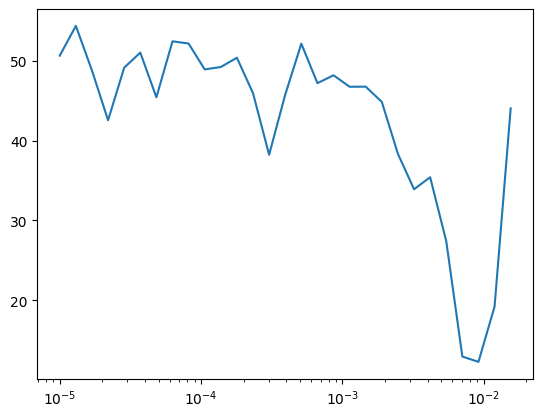

In [44]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

TimeR2Score,loss,epoch,train,time
0.752,11.692,0,True,00:00
0.936,3.024,0,False,00:00
0.960,1.865,1,True,00:00
0.947,2.518,1,False,00:00


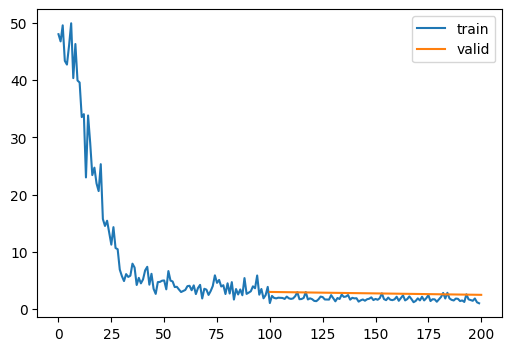

In [45]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [46]:
from functools import partial

In [47]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [48]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD, metric_fn=metric_fn):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    preds = {}
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = metric_fn()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        preds[dl_name] = torch.concat([ap, cps[0].all_targs], dim=1)  # Saving predictions
        print('result: ', metric.compute())
    return preds

In [49]:
nlearn = 3

Training models


TimeR2Score,loss,epoch,train,time
0.756,11.548,0,True,00:00
0.934,3.264,0,False,00:00
0.958,1.993,1,True,00:00
0.945,2.695,1,False,00:00


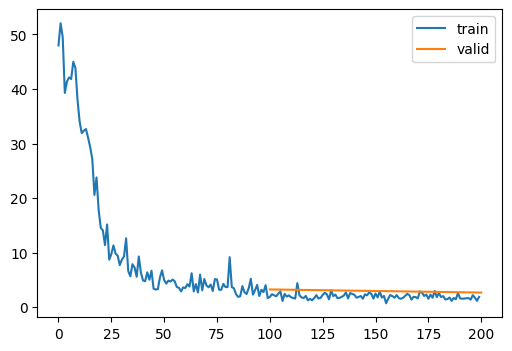

TimeR2Score,loss,epoch,train,time
0.749,11.916,0,True,00:00
0.937,3.108,0,False,00:00
0.960,1.920,1,True,00:00
0.947,2.636,1,False,00:00


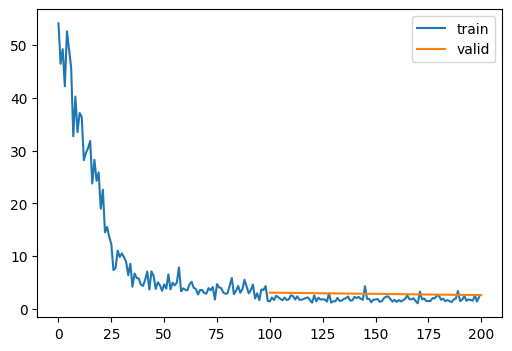

TimeR2Score,loss,epoch,train,time
0.743,12.056,0,True,00:00
0.935,3.020,0,False,00:00
0.959,1.949,1,True,00:00
0.948,2.406,1,False,00:00


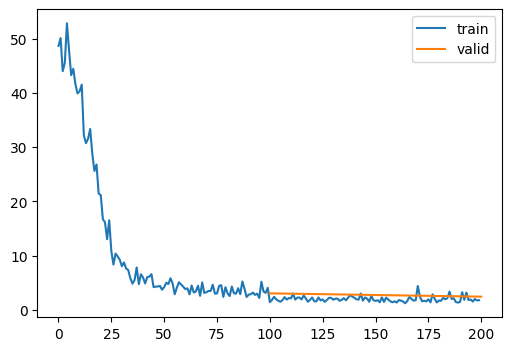

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.800,9.328,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.811,8.826,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.761,11.154,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 1.9134,  0.0000],
        [ 2.5852,  4.0000],
        [ 7.1345,  8.0000],
        [10.4000, 12.0000],
        [14.7997, 16.0000],
        [21.8906, 20.0000],
        [ 3.3556,  0.0000],
        [ 0.5193,  4.0000],
        [11.2637,  8.0000],
        [10.7393, 12.0000],
        [23.2443, 16.0000],
        [23.4558, 20.0000]])
result:  tensor(0.7964)


TimeR2Score,loss,epoch,train,time
0.641,25.816,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.656,16.273,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.910,4.236,0,False,00:00


Inference on gro
		preds, targs
tensor([[10.2444,  1.0000],
        [ 1.5092,  4.0000],
        [ 6.8797,  7.0000],
        [ 8.4861, 10.0000],
        [14.2603, 13.0000],
        [15.6880, 16.0000],
        [21.9488, 19.0000],
        [22.4075, 22.0000]])
result:  tensor(0.7235)


TimeR2Score,loss,epoch,train,time
0.771,10.695,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.660,15.862,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.808,8.970,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 2.6860,  2.0000],
        [ 7.4157,  6.0000],
        [ 7.9191, 10.0000],
        [13.8802, 14.0000],
        [22.3842, 18.0000],
        [22.9561, 22.0000],
        [ 2.7558,  2.0000],
        [ 6.8789,  6.0000],
        [10.7435, 10.0000],
        [12.8669, 14.0000],
        [22.0591, 18.0000],
        [12.4734, 22.0000]])
result:  tensor(0.7547)


TimeR2Score,loss,epoch,train,time
0.757,130.225,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.742,129.746,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.780,126.681,0,False,00:01


Inference on more
		preds, targs
tensor([[11.9611, 22.0000],
        [11.9113, 22.0000],
        [ 9.2330, 10.0000],
        ...,
        [20.6234, 19.5000],
        [ 9.8952,  7.5000],
        [11.6841, 13.5000]])
result:  tensor(0.7623)


In [50]:
preds = ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [51]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

## Batchnorm

In [52]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

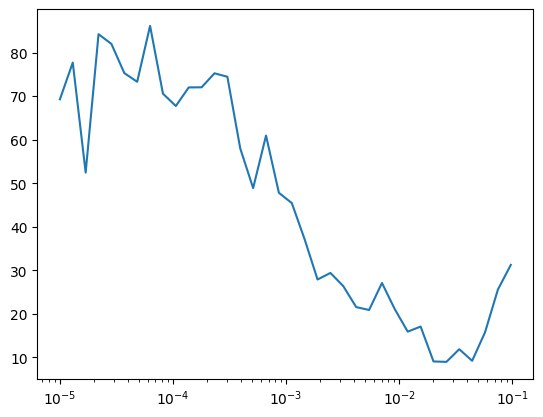

In [53]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


TimeR2Score,loss,epoch,train,time
0.879,6.299,0,True,00:00
0.898,5.222,0,False,00:00
0.941,3.014,1,True,00:00
0.963,2.147,1,False,00:00
0.963,1.761,2,True,00:00
0.975,1.336,2,False,00:00
0.977,1.125,3,True,00:00
0.978,1.117,3,False,00:00


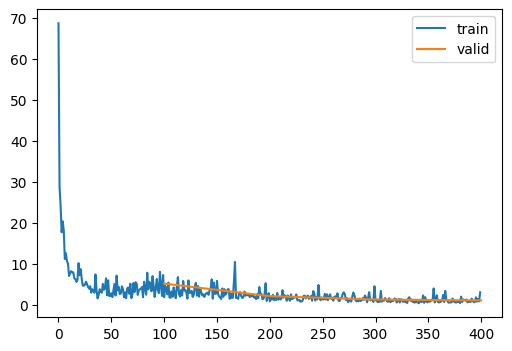

TimeR2Score,loss,epoch,train,time
0.876,6.448,0,True,00:00
0.927,4.186,0,False,00:00
0.929,3.673,1,True,00:00
0.953,2.385,1,False,00:00
0.962,1.842,2,True,00:00
0.970,1.516,2,False,00:00
0.976,1.126,3,True,00:00
0.977,1.203,3,False,00:00


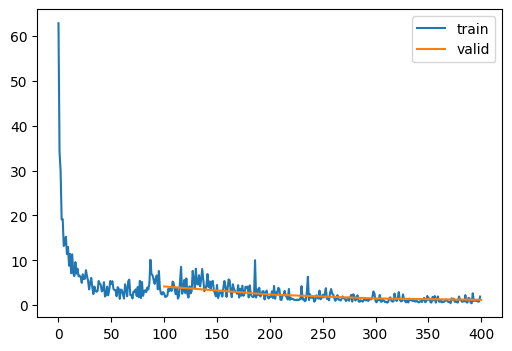

TimeR2Score,loss,epoch,train,time
0.874,6.730,0,True,00:00
0.938,3.094,0,False,00:00
0.941,3.188,1,True,00:00
0.960,2.074,1,False,00:00
0.962,1.909,2,True,00:00
0.972,1.564,2,False,00:00
0.976,1.103,3,True,00:00
0.977,1.316,3,False,00:00


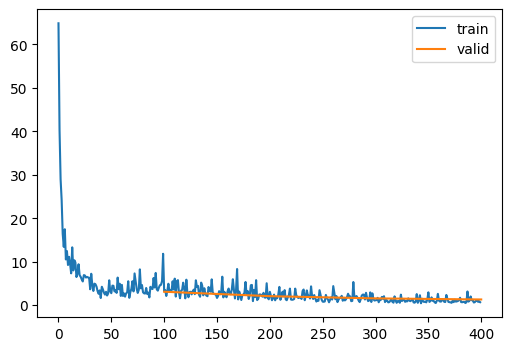

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.857,6.672,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.843,7.311,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.872,5.953,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 0.9704,  0.0000],
        [ 4.3344,  4.0000],
        [ 6.2141,  8.0000],
        [ 9.9165, 12.0000],
        [13.9157, 16.0000],
        [18.7993, 20.0000],
        [ 1.5421,  0.0000],
        [ 0.9265,  4.0000],
        [10.1920,  8.0000],
        [10.3315, 12.0000],
        [22.5685, 16.0000],
        [21.3557, 20.0000]])
result:  tensor(0.8593)


TimeR2Score,loss,epoch,train,time
0.968,1.507,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.943,2.680,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.973,1.256,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.1131,  1.0000],
        [ 3.3779,  4.0000],
        [ 6.0840,  7.0000],
        [ 9.2696, 10.0000],
        [14.0539, 13.0000],
        [13.1555, 16.0000],
        [19.0865, 19.0000],
        [21.3321, 22.0000]])
result:  tensor(0.9665)


TimeR2Score,loss,epoch,train,time
0.882,27.750,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.912,34.277,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.895,27.837,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 1.0815,  2.0000],
        [ 5.9870,  6.0000],
        [ 9.3551, 10.0000],
        [14.1461, 14.0000],
        [20.3357, 18.0000],
        [22.1798, 22.0000],
        [ 1.0564,  2.0000],
        [ 6.1337,  6.0000],
        [10.1083, 10.0000],
        [10.9654, 14.0000],
        [20.5312, 18.0000],
        [ 3.7199, 22.0000]])
result:  tensor(0.9000)


TimeR2Score,loss,epoch,train,time
0.760,127.575,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.761,130.964,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.775,125.387,0,False,00:01


Inference on more
		preds, targs
tensor([[ 8.4163, 22.0000],
        [10.7771, 22.0000],
        [ 8.2771, 10.0000],
        ...,
        [19.5244, 19.5000],
        [ 7.8269,  7.5000],
        [10.6445, 13.5000]])
result:  tensor(0.7663)


In [54]:
lr, epochs = .2, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [55]:
preds_df = pd.DataFrame(preds['more'], columns=['preds', 'targets'])
preds_df

,preds,targets
0,8.416280,22.0
1,10.777081,22.0
2,8.277131,10.0
3,13.176488,18.0
4,12.863826,2.0
...,...,...
1091,12.922700,13.5
1092,8.841857,7.5
1093,19.524376,19.5
1094,7.826910,7.5


In [56]:
preds_df.to_csv('preds_1574_2_4.csv')

Training models


TimeR2Score,loss,epoch,train,time
0.861,7.093,0,True,00:00
0.944,3.572,0,False,00:00
0.946,2.691,1,True,00:00
0.953,3.024,1,False,00:00
0.964,1.748,2,True,00:00
0.971,1.628,2,False,00:00
0.977,1.073,3,True,00:00
0.973,1.483,3,False,00:00


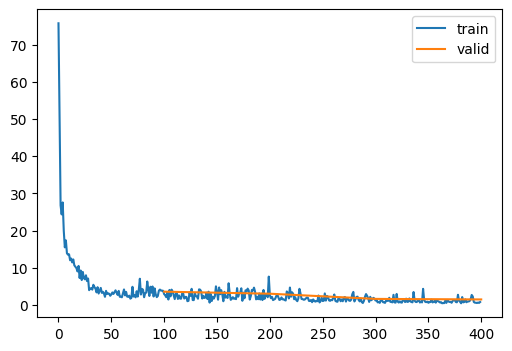

TimeR2Score,loss,epoch,train,time
0.863,7.226,0,True,00:00
0.950,2.551,0,False,00:00
0.945,2.822,1,True,00:00
0.964,1.954,1,False,00:00
0.969,1.493,2,True,00:00
0.974,1.360,2,False,00:00
0.980,0.982,3,True,00:00
0.974,1.294,3,False,00:00


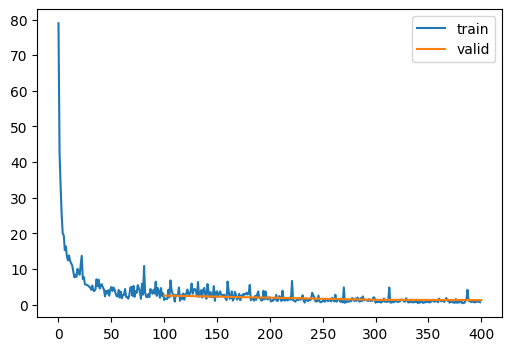

TimeR2Score,loss,epoch,train,time
0.872,6.692,0,True,00:00
0.933,3.565,0,False,00:00
0.944,3.036,1,True,00:00
0.963,1.953,1,False,00:00
0.968,1.536,2,True,00:00
0.970,1.438,2,False,00:00
0.979,0.978,3,True,00:00
0.974,1.296,3,False,00:00


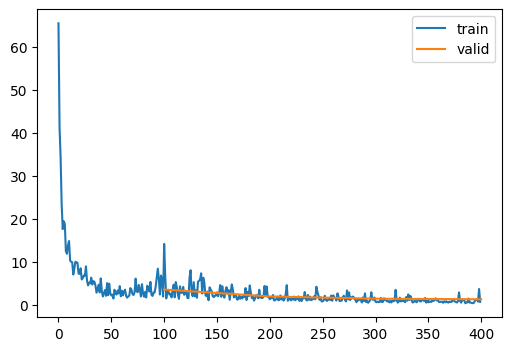

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.864,6.369,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.842,7.383,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.866,6.254,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 0.7649,  0.0000],
        [ 5.0792,  4.0000],
        [ 5.8321,  8.0000],
        [ 9.7597, 12.0000],
        [13.4475, 16.0000],
        [19.0023, 20.0000],
        [ 1.6057,  0.0000],
        [ 0.8112,  4.0000],
        [11.2178,  8.0000],
        [10.8155, 12.0000],
        [21.8903, 16.0000],
        [20.6729, 20.0000]])
result:  tensor(0.8596)


TimeR2Score,loss,epoch,train,time
0.973,1.287,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.966,1.624,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.952,2.249,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 1.0265,  1.0000],
        [ 2.4058,  4.0000],
        [ 6.0594,  7.0000],
        [ 9.0101, 10.0000],
        [14.2133, 13.0000],
        [14.0205, 16.0000],
        [19.1743, 19.0000],
        [20.1383, 22.0000]])
result:  tensor(0.9648)


TimeR2Score,loss,epoch,train,time
0.920,33.373,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.921,33.415,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.820,19.657,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 0.5477,  2.0000],
        [ 6.1996,  6.0000],
        [ 9.2030, 10.0000],
        [14.0243, 14.0000],
        [20.2871, 18.0000],
        [21.8052, 22.0000],
        [ 0.7144,  2.0000],
        [ 5.9496,  6.0000],
        [10.2862, 10.0000],
        [11.4769, 14.0000],
        [20.0846, 18.0000],
        [ 4.1156, 22.0000]])
result:  tensor(0.8966)


TimeR2Score,loss,epoch,train,time
0.787,123.696,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.782,129.216,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.766,124.668,0,False,00:01


Inference on more
		preds, targs
tensor([[ 8.0934, 22.0000],
        [11.5013, 22.0000],
        [ 7.9103, 10.0000],
        ...,
        [18.8970, 19.5000],
        [ 6.9408,  7.5000],
        [10.9756, 13.5000]])
result:  tensor(0.7739)


In [57]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [58]:
preds_df = pd.DataFrame(preds['more'], columns=['preds', 'targets'])
preds_df

,preds,targets
0,8.093403,22.0
1,11.501346,22.0
2,7.910329,10.0
3,13.408511,18.0
4,13.700437,2.0
...,...,...
1091,13.031940,13.5
1092,6.995934,7.5
1093,18.896971,19.5
1094,6.940836,7.5


In [59]:
preds_df.to_csv('preds_1574_1_4.csv')

Training models


TimeR2Score,loss,epoch,train,time
0.881,6.448,0,True,00:00
0.944,3.268,0,False,00:00
0.927,3.854,1,True,00:00
0.961,2.197,1,False,00:00
0.952,2.390,2,True,00:00
0.967,1.829,2,False,00:00
0.967,1.562,3,True,00:00
0.974,1.462,3,False,00:00
0.980,0.950,4,True,00:00
0.979,1.229,4,False,00:00


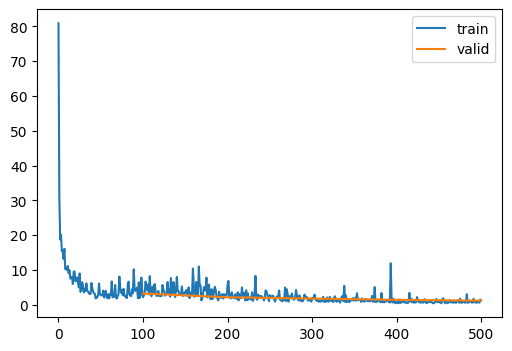

TimeR2Score,loss,epoch,train,time
0.880,6.235,0,True,00:00
0.923,4.699,0,False,00:00
0.924,3.905,1,True,00:00
0.941,3.032,1,False,00:00
0.948,2.524,2,True,00:00
0.969,1.558,2,False,00:00
0.969,1.503,3,True,00:00
0.977,1.270,3,False,00:00
0.978,1.018,4,True,00:00
0.979,1.148,4,False,00:00


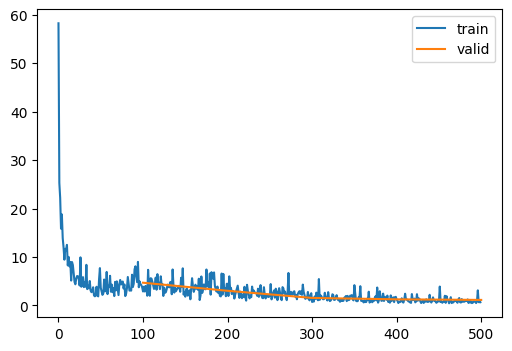

TimeR2Score,loss,epoch,train,time
0.878,6.328,0,True,00:00
0.942,3.305,0,False,00:00
0.928,3.762,1,True,00:00
0.950,2.864,1,False,00:00
0.952,2.371,2,True,00:00
0.965,1.675,2,False,00:00
0.966,1.624,3,True,00:00
0.973,1.261,3,False,00:00
0.980,0.946,4,True,00:00
0.976,1.128,4,False,00:00


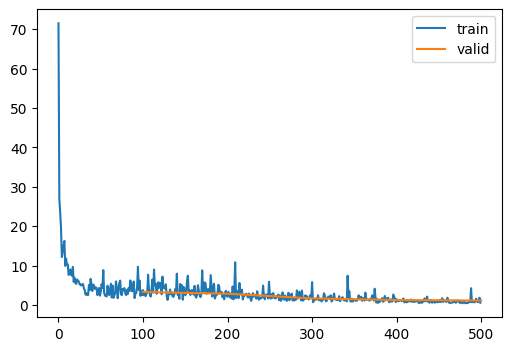

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.850,7.002,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.855,6.774,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.870,6.067,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 0.5559,  0.0000],
        [ 4.7873,  4.0000],
        [ 6.2914,  8.0000],
        [ 9.6795, 12.0000],
        [13.9619, 16.0000],
        [18.4562, 20.0000],
        [ 1.4050,  0.0000],
        [ 0.8968,  4.0000],
        [10.7567,  8.0000],
        [10.2896, 12.0000],
        [22.1813, 16.0000],
        [20.8930, 20.0000]])
result:  tensor(0.8627)


TimeR2Score,loss,epoch,train,time
0.957,2.016,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.937,2.961,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.964,1.715,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.2369,  1.0000],
        [ 2.9576,  4.0000],
        [ 6.0318,  7.0000],
        [ 9.0702, 10.0000],
        [13.8362, 13.0000],
        [13.0528, 16.0000],
        [18.8004, 19.0000],
        [20.6602, 22.0000]])
result:  tensor(0.9586)


TimeR2Score,loss,epoch,train,time
0.904,30.383,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.923,32.705,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.739,14.951,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 0.8466,  2.0000],
        [ 6.1647,  6.0000],
        [ 8.7514, 10.0000],
        [14.0725, 14.0000],
        [19.6089, 18.0000],
        [21.0148, 22.0000],
        [ 0.9023,  2.0000],
        [ 6.1238,  6.0000],
        [10.1951, 10.0000],
        [10.7107, 14.0000],
        [19.2341, 18.0000],
        [ 5.1879, 22.0000]])
result:  tensor(0.8719)


TimeR2Score,loss,epoch,train,time
0.763,125.792,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.760,127.310,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.761,127.773,0,False,00:01


Inference on more
		preds, targs
tensor([[ 7.8517, 22.0000],
        [11.6513, 22.0000],
        [ 8.5644, 10.0000],
        ...,
        [18.9490, 19.5000],
        [ 6.7730,  7.5000],
        [10.6145, 13.5000]])
result:  tensor(0.7610)


In [60]:
lr, epochs = .3, 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [61]:
preds_df = pd.DataFrame(preds['more'], columns=['preds', 'targets'])
preds_df

,preds,targets
0,7.851746,22.0
1,11.651296,22.0
2,8.564442,10.0
3,12.955941,18.0
4,12.945947,2.0
...,...,...
1091,12.424926,13.5
1092,7.481471,7.5
1093,18.949024,19.5
1094,6.772952,7.5


In [62]:
preds_df.to_csv('preds_1574_3_5.csv')

Training models


TimeR2Score,loss,epoch,train,time
0.850,7.580,0,True,00:00
0.962,2.103,0,False,00:00
0.946,2.869,1,True,00:00
0.949,2.752,1,False,00:00
0.958,2.150,2,True,00:00
0.965,2.003,2,False,00:00
0.974,1.227,3,True,00:00
0.977,1.229,3,False,00:00
0.983,0.776,4,True,00:00
0.981,1.021,4,False,00:00


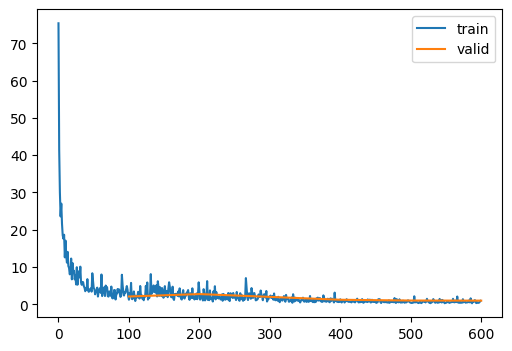

TimeR2Score,loss,epoch,train,time
0.853,7.494,0,True,00:00
0.950,2.747,0,False,00:00
0.946,2.695,1,True,00:00
0.956,2.571,1,False,00:00
0.954,2.326,2,True,00:00
0.962,2.275,2,False,00:00
0.973,1.320,3,True,00:00
0.970,1.679,3,False,00:00
0.983,0.828,4,True,00:00
0.977,1.190,4,False,00:00


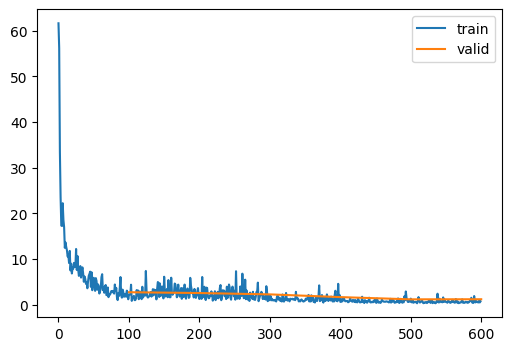

TimeR2Score,loss,epoch,train,time
0.859,7.214,0,True,00:00
0.951,2.824,0,False,00:00
0.947,2.733,1,True,00:00
0.950,3.089,1,False,00:00
0.958,2.029,2,True,00:00
0.966,1.840,2,False,00:00
0.972,1.307,3,True,00:00
0.979,1.121,3,False,00:00
0.981,0.914,4,True,00:00
0.979,1.101,4,False,00:00


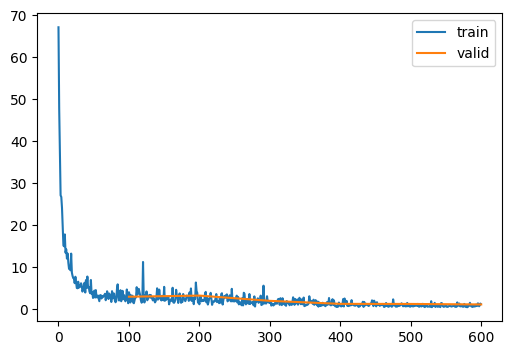

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.908,4.288,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.847,7.123,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.887,5.295,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 0.7970,  0.0000],
        [ 5.3354,  4.0000],
        [ 6.5351,  8.0000],
        [ 9.8427, 12.0000],
        [13.7593, 16.0000],
        [18.8733, 20.0000],
        [ 1.6604,  0.0000],
        [ 1.3193,  4.0000],
        [10.4858,  8.0000],
        [10.3324, 12.0000],
        [21.4059, 16.0000],
        [21.2732, 20.0000]])
result:  tensor(0.8835)


TimeR2Score,loss,epoch,train,time
0.969,1.480,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.962,1.817,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.986,0.683,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 0.8138,  1.0000],
        [ 3.2750,  4.0000],
        [ 6.3241,  7.0000],
        [ 9.2916, 10.0000],
        [14.4610, 13.0000],
        [13.9344, 16.0000],
        [18.9904, 19.0000],
        [20.6844, 22.0000]])
result:  tensor(0.9745)


TimeR2Score,loss,epoch,train,time
0.890,27.066,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.886,30.261,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.910,29.556,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 0.7034,  2.0000],
        [ 6.1599,  6.0000],
        [ 9.4910, 10.0000],
        [13.8831, 14.0000],
        [20.2686, 18.0000],
        [21.8893, 22.0000],
        [ 0.7406,  2.0000],
        [ 6.1736,  6.0000],
        [10.0179, 10.0000],
        [11.2865, 14.0000],
        [20.3422, 18.0000],
        [ 3.9845, 22.0000]])
result:  tensor(0.8975)


TimeR2Score,loss,epoch,train,time
0.780,127.835,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.774,128.112,0,False,00:01


TimeR2Score,loss,epoch,train,time
0.775,129.943,0,False,00:01


Inference on more
		preds, targs
tensor([[ 9.5741, 22.0000],
        [11.0582, 22.0000],
        [ 8.5259, 10.0000],
        ...,
        [18.8040, 19.5000],
        [ 7.4597,  7.5000],
        [10.7151, 13.5000]])
result:  tensor(0.7745)


In [63]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
preds = ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

In [64]:
preds.keys()

dict_keys(['nascent', 'gro', 'rna', 'more'])

In [65]:
preds_df = pd.DataFrame(preds['more'], columns=['preds', 'targets'])
preds_df

,preds,targets
0,9.574142,22.0
1,11.058193,22.0
2,8.525940,10.0
3,13.604520,18.0
4,13.559826,2.0
...,...,...
1091,13.078946,13.5
1092,9.230133,7.5
1093,18.804007,19.5
1094,7.459709,7.5


In [66]:
preds_df.to_csv('preds_1574_1_6.csv')

In [63]:
torch.set_printoptions(edgeitems=15, linewidth=100)

Training models


TimeR2Score,loss,epoch,train,time
0.771,10.760,0,True,00:06
0.849,6.734,0,False,00:01


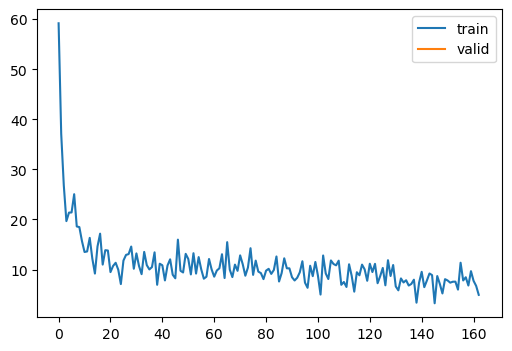

TimeR2Score,loss,epoch,train,time
0.774,10.736,0,True,00:07
0.852,6.643,0,False,00:01


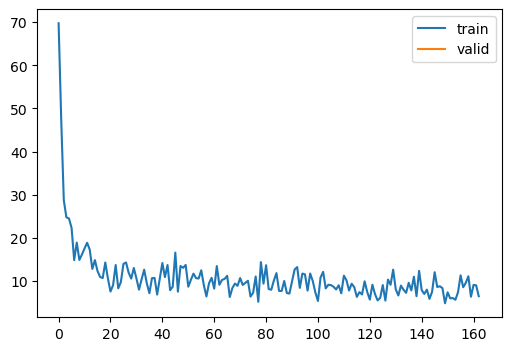

Making inference on test data


TimeR2Score,loss,epoch,train,time
0.517,27.027,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.532,32.926,0,False,00:00


Inference on nascent
		preds, targs
tensor([[13.9479,  0.0000],
        [ 3.1151,  4.0000],
        [12.2396,  8.0000],
        [ 5.1389, 12.0000],
        [12.4784, 16.0000],
        [22.4060, 20.0000],
        [ 1.1477,  0.0000],
        [ 1.1355,  4.0000],
        [14.1972,  8.0000],
        [ 9.3857, 12.0000],
        [19.7294, 16.0000],
        [23.1241, 20.0000]])
result:  tensor(0.5295)


TimeR2Score,loss,epoch,train,time
0.558,20.891,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.630,24.108,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 2.9009,  1.0000],
        [ 6.9564,  4.0000],
        [ 7.1007,  7.0000],
        [10.1517, 10.0000],
        [13.3283, 13.0000],
        [ 3.6949, 16.0000],
        [21.9743, 19.0000],
        [20.8068, 22.0000]])
result:  tensor(0.5779)


TimeR2Score,loss,epoch,train,time
0.473,36.671,0,False,00:00


TimeR2Score,loss,epoch,train,time
0.350,60.456,0,False,00:00


Inference on rna
		preds, targs
tensor([[10.9873,  2.0000],
        [ 4.6267,  6.0000],
        [ 9.6859, 10.0000],
        [14.8856, 14.0000],
        [23.1716, 18.0000],
        [21.7847, 22.0000],
        [ 2.8924,  2.0000],
        [10.5423,  6.0000],
        [12.6655, 10.0000],
        [10.5984, 14.0000],
        [ 7.2441, 18.0000],
        [ 4.7737, 22.0000]])
result:  tensor(0.4428)


TimeR2Score,loss,epoch,train,time
0.684,132.771,0,False,00:05


TimeR2Score,loss,epoch,train,time
0.677,142.734,0,False,00:05


Inference on more
		preds, targs
tensor([[ 6.0791, 22.0000],
        [ 6.1594, 22.0000],
        [ 9.2075, 10.0000],
        [12.9036, 18.0000],
        [ 9.1739,  2.0000],
        [13.4108, 18.0000],
        [10.5875, 14.0000],
        [ 3.7824,  6.0000],
        [ 4.1267,  6.0000],
        [11.4954, 14.0000],
        [ 8.6984, 10.0000],
        [12.5296,  2.0000],
        [17.2509, 24.0000],
        [17.9406, 21.0000],
        [ 9.1039, 33.0000],
        ...,
        [15.7182,  7.5000],
        [21.0383,  1.5000],
        [15.7897, 16.5000],
        [21.6692,  4.5000],
        [20.1095, 22.5000],
        [17.2903, 16.5000],
        [22.1280,  1.5000],
        [14.6939, 10.5000],
        [17.7376, 16.5000],
        [21.8308,  1.5000],
        [14.1764, 13.5000],
        [14.5840,  7.5000],
        [20.8307, 19.5000],
        [13.4561,  7.5000],
        [15.4208, 13.5000]])
result:  tensor(0.6826)


{'nascent': tensor([[13.9479,  0.0000],
         [ 3.1151,  4.0000],
         [12.2396,  8.0000],
         [ 5.1389, 12.0000],
         [12.4784, 16.0000],
         [22.4060, 20.0000],
         [ 1.1477,  0.0000],
         [ 1.1355,  4.0000],
         [14.1972,  8.0000],
         [ 9.3857, 12.0000],
         [19.7294, 16.0000],
         [23.1241, 20.0000]]),
 'gro': tensor([[ 2.9009,  1.0000],
         [ 6.9564,  4.0000],
         [ 7.1007,  7.0000],
         [10.1517, 10.0000],
         [13.3283, 13.0000],
         [ 3.6949, 16.0000],
         [21.9743, 19.0000],
         [20.8068, 22.0000]]),
 'rna': tensor([[10.9873,  2.0000],
         [ 4.6267,  6.0000],
         [ 9.6859, 10.0000],
         [14.8856, 14.0000],
         [23.1716, 18.0000],
         [21.7847, 22.0000],
         [ 2.8924,  2.0000],
         [10.5423,  6.0000],
         [12.6655, 10.0000],
         [10.5984, 14.0000],
         [ 7.2441, 18.0000],
         [ 4.7737, 22.0000]]),
 'more': tensor([[ 6.0791, 22.0000],
    

In [64]:
lr, epochs = .3, 1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)